# Lab 1 Evaluation

Group B1
Aubut Guillaume
Pastor Emmanuel

In the following, we consider the  (binarized) Compas dataset that we studied in the Lab

**A decision tree configuration is a set of parameters that one can use to build decision trees. Propose 6 configurations that are likely to provide different topologies and caracteristics**

* configuration 1: splitter="best", max_depth=2, min_samples_leaf=50
* configuration 2: splitter="best", max_depth=4, min_samples_leaf=50
* configuration 3: splitter="random", max_depth=4, min_samples_leaf=100
* configuration 4: splitter="random", max_depth=2, min_samples_leaf=16
* configuration 5: splitter="random", max_depth=4, min_samples_leaf=4
* configuration 6: splitter="best", max_depth=8, min_samples_leaf=4

**Train a decision tree for each of the previous configurations on the full dataset**

In [2]:
from sklearn import tree, model_selection, metrics
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import csv
import numpy as np
from utils import load_from_csv
import  pandas as pd

In [3]:
train_examples, train_labels, features, prediction = load_from_csv("./compass.csv")

In [ ]:
params = [["best", 2, 50],
          ["best", 4, 50],
          ["random", 4, 100],
          ["random", 2, 16],
          ["random", 4, 4],
          ["best", 8, 4]]

for i in range(len(params)):
    clf = tree.DecisionTreeClassifier(splitter=params[i][0], max_depth=params[i][1], min_samples_leaf=params[i][2])
    clf = clf.fit(train_examples, train_labels)

    plt.figure(figsize=(50,20))
    tree.plot_tree(clf,feature_names= tuple(features),class_names= (prediction, "NO_" + prediction ),filled=True)
    title = "splitter=" + str(params[i][0]) + ", max_depth=" + str(params[i][1]) + ", min_samples_leaf=" + str(params[i][2])
    plt.title(title, loc="center", fontdict={'fontsize': 40, 'fontweight': 'bold'})
    plt.show()

**Propose an evaluation in terms of training and testing accuracies using $5$-cross validation on two decision trees that have different typologies**

In [6]:
results = []
for i in (0,2):
    clf = tree.DecisionTreeClassifier(splitter=params[i][0], max_depth=params[i][1], min_samples_leaf=params[i][2])
    score = model_selection.cross_validate(clf, train_examples, train_labels, cv=5, return_train_score=True)
    results.append({'splitter': params[i][0],
                    'max_depth': params[i][1],
                    'min_samples_leaf': params[i][2],
                    'training accuracy': score['train_score'].mean(),
                    'testing accuracy': score['test_score'].mean()})
table = pd.DataFrame.from_dict(results)
table

,splitter,max_depth,min_samples_leaf,training accuracy,testing accuracy
0,best,2,50,0.635834,0.630191
1,random,4,100,0.668216,0.659586


**Propose an experimental study that shows the transition phase from underfitting to overfitting**

We are going to show the transition from underfitting to overfitting by calcuating the train and test accuracy for various `max_depth` and `min_samples_leaf` values and showing them in graphs.

Making `max_depth` vary: 

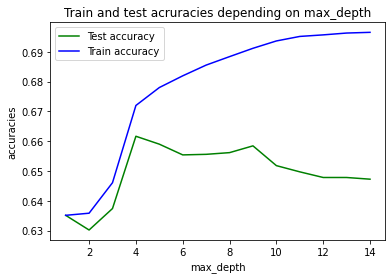

In [8]:
depth_range = np.arange(1, 15, 1)
testAccuracy = []
trainAccuracy = []
for i in depth_range:
    clf = tree.DecisionTreeClassifier(max_depth=i)
    score = model_selection.cross_validate(clf, train_examples, train_labels, cv=5, return_train_score=True)
    testAccuracy.append(score['test_score'].mean())
    trainAccuracy.append(score['train_score'].mean())

plt.figure(0)
plt.plot(depth_range, testAccuracy, c="g", label="Test accuracy")
plt.plot(depth_range, trainAccuracy, c="b", label="Train accuracy")
plt.xlabel("max_depth")
plt.ylabel("accuracies")
plt.legend(loc="upper left")
plt.title("Train and test acruracies depending on max_depth")
plt.show()

On the graph above, we can see **underfitting** for `max_depth` values form 1 to 4. Indeed, accuracies for training and testing are very similar and train accuracy is lower than it could be.
Then with a `max_depth` between 4 and 9, the training accuracy keeps improving but test accuracy remain stable, before decreasing after 9.
That test accuracy decrease while train accuracy is still increasing is a sign of **overfitting**.
Based on this graph, we could say that a `max_depth` of 9 is most optimal in this situation.


Making `min_samples_leaf` vary: 

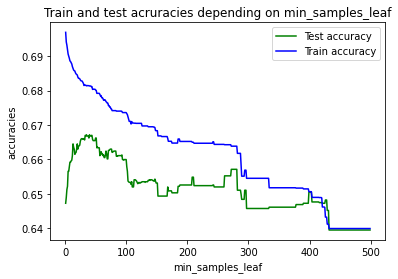

In [12]:
samples_leaf_range = np.arange(1, 500, 1)
testAccuracy = []
trainAccuracy = []
for i in samples_leaf_range:
    clf = tree.DecisionTreeClassifier(min_samples_leaf=i)
    score = model_selection.cross_validate(clf, train_examples, train_labels, cv=5, return_train_score=True)
    testAccuracy.append(score['test_score'].mean())
    trainAccuracy.append(score['train_score'].mean())

plt.figure(0)
plt.plot(samples_leaf_range, testAccuracy, c="g", label="Test accuracy")
plt.plot(samples_leaf_range, trainAccuracy, c="b", label="Train accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracies")
plt.legend(loc="upper right")
plt.title("Train and test acruracies depending on min_samples_leaf")
plt.show()

At the beginning we can see **overfitting** with the training accuracy being substentially higher than the testing accuracy.
Then the two accuracies decrease until they end up being almost the same giving a sign of **underfitting**.
The good fit seems to be around 280 or 270.

**Construct the confusion matrix on a particular good configuration (after explaining your choice)**

As mentioned previously, given the previous graphs, a `max_depth` of 9 and a `min_samples_leaf` of 280 look like a good fit. They seem to avoid overfitting and underfitting.

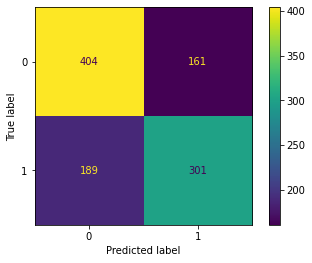

In [15]:
max_depth = 9
min_samples_leaf = 280
(x_train, x_test, y_train, y_test) = model_selection.train_test_split(train_examples, train_labels, test_size=0.2, random_state=44)
clf = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

We can see that a good majority of exmaples are classified properly. But as we saw in the graphs, the accuracy of the model is around 65% so that explains the number of false positives and false negatives

**Provide an evaluation of the fairness of the model based on the False Positive Rate**

In [15]:
x_caucasian = []
y_caucasian = []
x_african_american = []
y_african_american = []
for i in range(len(train_examples)):
    if train_examples[i][0]==0:
        x_caucasian.append(train_examples[i])
        y_caucasian.append(train_labels[i])
    else:
        x_african_american.append(train_examples[i])
        y_african_american.append(train_labels[i])

Caucasian people

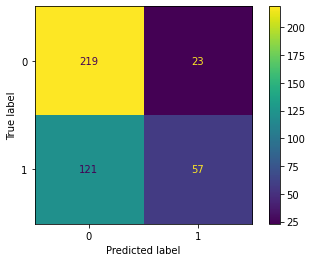

In [16]:
max_depth = 9
min_samples_leaf = 280
(x_train, x_test, y_train, y_test) = model_selection.train_test_split(x_caucasian, y_caucasian, test_size=0.2, random_state=44)
clf = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
clf = clf.fit(x_caucasian, y_caucasian)
y_pred = clf.predict(x_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

African American people

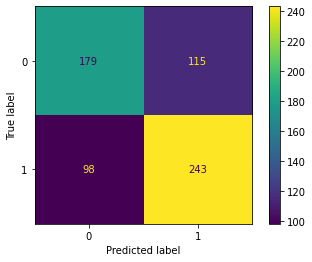

In [17]:
max_depth = 9
min_samples_leaf = 280
(x_train, x_test, y_train, y_test) = model_selection.train_test_split(x_african_american, y_african_american, test_size=0.2, random_state=44)
clf = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
clf = clf.fit(x_african_american, y_african_american)
y_pred = clf.predict(x_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Given the confusion matrix for Caucasian and African American people, we can see from the false positive rate (in the upper right corner) that the model is not fair.
With this model, **African American people are 5 times more likely to be wrongly classified as future recidivists than Caucasian people**.